In [75]:
import pandas as pd
import numpy as np

In [76]:
book_df_origin = pd.read_pickle('./small_Books.pkl')

In [77]:
meta_df_origin = pd.read_pickle('./small_meta_Books.pkl')

In [78]:
book_df = book_df_origin.copy()
meta_df = meta_df_origin.copy()

In [79]:
print(meta_df.columns)
print(book_df.columns)

Index(['title', 'subtitle', 'author', 'average_rating', 'rating_number',
       'features', 'price', 'store', 'categories', 'details', 'parent_asin',
       'publish_time'],
      dtype='object')
Index(['rating', 'parent_asin', 'user_id', 'timestamp'], dtype='object')


In [80]:
original_title2id_dict = {}
id_num = 0 # start from 0
unique_titles = meta_df['title'].unique().tolist()
for title in unique_titles:
    original_title2id_dict[title] = id_num
    id_num+=1
    

In [81]:
meta_df['title_idx'] = meta_df['title'].apply(lambda x:original_title2id_dict[x])

# 1. seperate cold-start and warm-start items according to item publish time

In [82]:
print(book_df.columns, meta_df.columns)

Index(['rating', 'parent_asin', 'user_id', 'timestamp'], dtype='object') Index(['title', 'subtitle', 'author', 'average_rating', 'rating_number',
       'features', 'price', 'store', 'categories', 'details', 'parent_asin',
       'publish_time', 'title_idx'],
      dtype='object')


In [83]:
partial_meta_df = meta_df.copy()[['title','parent_asin','title_idx','publish_time']]

In [84]:
merged_book_df = pd.merge(left = book_df, right=partial_meta_df,how = 'left',on='parent_asin', )

In [85]:
print(merged_book_df.columns)

Index(['rating', 'parent_asin', 'user_id', 'timestamp', 'title', 'title_idx',
       'publish_time'],
      dtype='object')


In [86]:
data = merged_book_df.copy()

In [87]:
data.columns = ['rating', 'iid', 'uid', 'timestamp', 'title', 'title_idx','publish_time']
data['year'] = data['timestamp'].dt.year

In [88]:
print(data.head(5))

   rating         iid                           uid               timestamp  \
0       1  B09BGPFTDB  AFKZENTNBQ7A7V7UXW5JJI6UGRYQ 2022-01-17 06:06:38.485   
1       5  0593235657  AFKZENTNBQ7A7V7UXW5JJI6UGRYQ 2021-12-27 18:26:44.904   
2       5  1782490671  AFKZENTNBQ7A7V7UXW5JJI6UGRYQ 2021-12-24 22:04:55.102   
3       5  0593138228  AFKZENTNBQ7A7V7UXW5JJI6UGRYQ 2021-12-24 16:55:06.602   
4       5  0823098079  AFKZENTNBQ7A7V7UXW5JJI6UGRYQ 2021-11-19 08:57:33.230   

                                               title  title_idx publish_time  \
0  Watercolor with Me in the Ocean: Coloring book...    2838745   2021-07-29   
1  Get Untamed: The Journal (How to Quit Pleasing...    2306876   2021-11-16   
2  Cute & Easy Crochet with Flowers: 35 beautiful...     274944   2013-09-12   
3  The Pop Manga Sketchbook: A Guided Drawing Jou...    2119176   2021-06-01   
4  Haiku Knits: 25 Serenely Beautiful Patterns In...     331161   2009-10-20   

   year  
0  2022  
1  2021  
2  2021  
3  2

In [89]:
cold_publish_data = data[data['publish_time'] >= pd.to_datetime('2022-10-01')]
cold_publish_items = cold_publish_data['title_idx'].unique().tolist()

In [90]:
item_review_earliest_time = data.groupby('title_idx').agg({'timestamp':'min'})
print(item_review_earliest_time)

                        timestamp
title_idx                        
0         2013-05-15 17:16:16.000
1         2004-12-29 22:56:47.000
2         2012-05-09 10:59:08.000
3         2013-11-05 15:53:28.000
4         2014-06-21 21:41:50.000
...                           ...
3864962   2019-06-20 21:45:22.228
3864963   2014-11-12 21:32:34.000
3864964   2010-03-04 21:11:09.000
3864965   2003-07-28 16:41:06.000
3864966   2006-11-01 00:10:28.000

[3863285 rows x 1 columns]


In [91]:
cold_review_data = item_review_earliest_time[item_review_earliest_time['timestamp'] >= pd.to_datetime('2022-10-01')]
cold_review_items = cold_review_data.index.tolist()
print(cold_review_items[:10])

[11, 12, 32, 38, 39, 73, 104, 229, 245, 339]


In [92]:
cold_items = set(cold_review_items).intersection(set(cold_publish_items))

# 2.get warm_train, warm_test, cold_test data

In [93]:
warm_start_time = '2016-01-01'
cold_end_time = '2023-10-01'

In [94]:
data = merged_book_df.copy()
data.columns = ['rating', 'iid', 'uid', 'timestamp', 'title', 'title_idx','publish_time']
data['year'] = data['timestamp'].dt.year
data = data[(data['timestamp'] >= pd.to_datetime(warm_start_time)) & (data['timestamp'] <= pd.to_datetime(cold_end_time))]

<Axes: xlabel='month'>

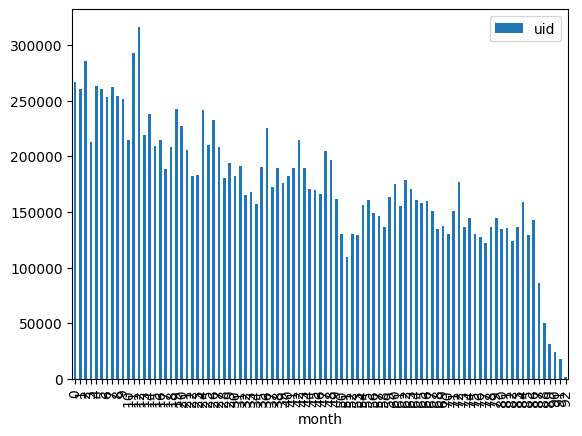

In [95]:
data['month'] = data['timestamp'].dt.month + data['timestamp'].dt.year * 12
data['month'] = data['month'] - data['month'].min()
data.groupby('month').agg({'uid':'count'}).reset_index().plot(x = 'month', kind = 'bar')

<Axes: xlabel='month'>

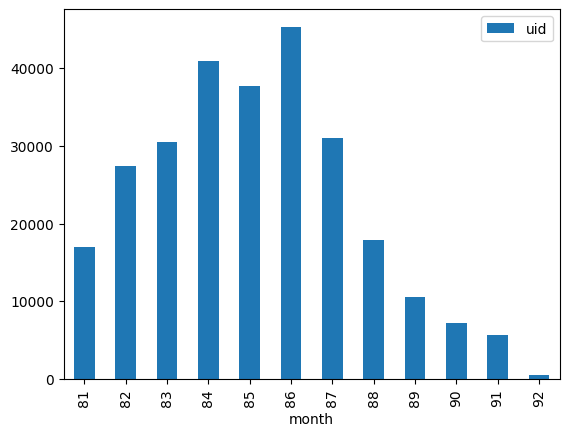

In [96]:
cold_data = data[data['title_idx'].isin(cold_items)]
cold_data.groupby('month').agg({'uid':'count'}).reset_index().plot(x = 'month', kind = 'bar')

<Axes: xlabel='month'>

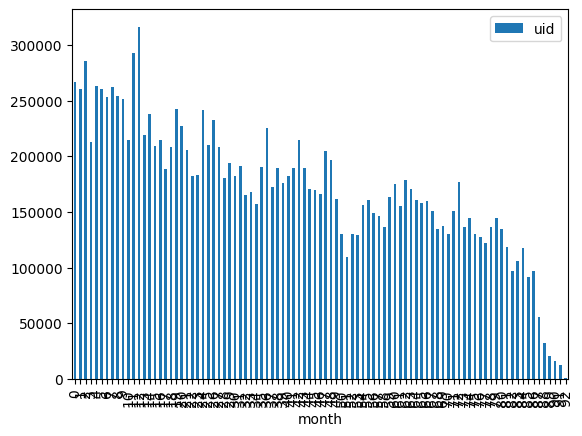

In [97]:
uncold_data = data[~data['title_idx'].isin(cold_items)]
uncold_data.groupby('month').agg({'uid':'count'}).reset_index().plot(x = 'month', kind = 'bar')

In [98]:
# delete cold data' interactions
test_months = list(range(data['month'].max()-12+1,data['month'].max() +1 )) 
cold_data_test = cold_data[cold_data['month'].isin(test_months)]
cold_items_test = cold_data_test['title_idx'].unique().tolist()

In [99]:
import random
old_items = uncold_data['iid'].unique().tolist()

old_items_in_test_set = uncold_data[uncold_data['month'].isin(test_months)]['iid'].unique().tolist()
old_items_in_train_set = uncold_data[~uncold_data['month'].isin(test_months)]['iid'].unique().tolist()

# items without interactions in training set
old_items_cold = list(set(old_items_in_test_set) - set(old_items_in_train_set)) # [item for item in old_items_in_test_set if item not in old_items_in_train_set]
random.seed(2024)
random.shuffle(old_items)



In [100]:
print(len(old_items_cold),len(old_items))
sample_items_cold = old_items[:int(len(old_items) * 0.2)]
fake_cold_items = list(set(old_items_cold) | set (sample_items_cold))
preserve_warm_items = list((set(old_items) - set(old_items_cold)) - set (sample_items_cold)) 
fake_cold_data_test = uncold_data[(uncold_data['month'].isin(test_months)) & uncold_data['iid'].isin(fake_cold_items)]

121095 2924077


<Axes: xlabel='month'>

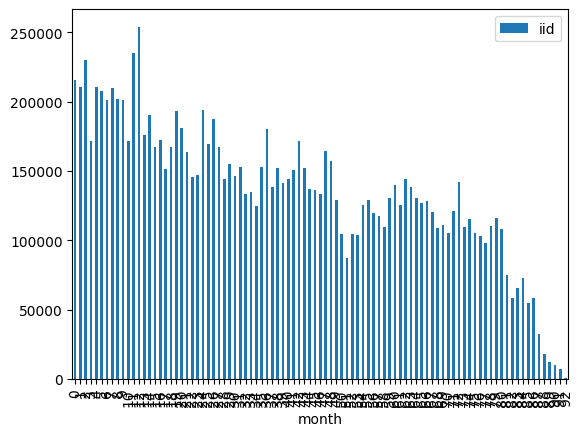

In [101]:
preserve_warm_data = uncold_data[uncold_data['iid'].isin(preserve_warm_items)]
cnt_warm = preserve_warm_data['iid'].value_counts() 
preserve_warm_data.groupby('month').agg({'iid':'count'}).reset_index().plot(x = 'month', kind = 'bar')

In [102]:
# process only warm_data
preserve_warm_data_test = preserve_warm_data[preserve_warm_data['month'].isin(test_months)]
preserve_warm_data_train = preserve_warm_data[~preserve_warm_data['month'].isin(test_months)]

In [103]:
preserve_warm_data_train['env'] = 0 # warm train
preserve_warm_data_test['env'] = 1
# the fake cold data denote items published before '2022-10-31',  
# which means their text information may be collected in LLAMA-2's pretraining stage.
# However, these items were not used in our final paper.
fake_cold_data_test['env'] = 2
cold_data_test['env'] = 3
all_data = pd.concat([preserve_warm_data_train,preserve_warm_data_test,fake_cold_data_test,cold_data_test])


/tmp/ipykernel_2758286/2279802373.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preserve_warm_data_train['env'] = 0 # warm train
/tmp/ipykernel_2758286/2279802373.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preserve_warm_data_test['env'] = 1
/tmp/ipykernel_2758286/2279802373.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

In [104]:
def filter_users(all_data):
    user_cnt = all_data['uid'].value_counts()
    warm_users = user_cnt[user_cnt >= 15].index.tolist()
    all_data = all_data[all_data['uid'].isin(warm_users)]
    return all_data

In [105]:
# filter items, preserve all items with interaction >= 10.
def filer_items(all_data):
    item_cnt = all_data['iid'].value_counts()
    filer_items = item_cnt[item_cnt >= 15].index.tolist()
    all_data = all_data[all_data['iid'].isin(filer_items)]
    train_warm_cnt = all_data[all_data['env'] == 0]['iid'].value_counts()
    delete_items = train_warm_cnt[train_warm_cnt < 15].index.unique().tolist()
    all_data = all_data[~all_data['iid'].isin(delete_items)]
    return all_data

In [106]:
all_data = filter_users(all_data)
all_data = filer_items(all_data)

In [107]:
print(all_data.shape[0])
print(all_data[all_data['env'] == 0].shape[0]) # warm_train
print(all_data[all_data['env'] == 1].shape[0]) # warm_test
print(all_data[all_data['env'] == 3].shape[0]) # cold

print(all_data[all_data['env'] == 0]['iid'].value_counts())
print(all_data[all_data['env'] == 1]['iid'].value_counts())
print(all_data[all_data['env'] == 3]['iid'].value_counts())

788105
737643
20833
23654
iid
B01M7XPGYE    784
B06Y1264PX    754
B01KXQ8SS6    664
B01EN506CO    593
B01BU1ITMI    579
             ... 
B082H71XVG     15
B0974521FG     15
1626345848     15
1542033837     15
1250150876     15
Name: count, Length: 20824, dtype: int64
iid
B09QXZB6SK    135
0593358511    109
B09JBCGQB8     79
1668002175     77
B091M75X6J     65
             ... 
1645437639      1
1328635201      1
0399557253      1
1250252687      1
B077C8GFSX      1
Name: count, Length: 7259, dtype: int64
iid
125028001X    266
1984818384    250
B09ZK4KVTX    201
1250803853    149
B09TZM8CZK    145
             ... 
1647422531     15
B09ZB5VNHG     15
1250846528     15
1538700433     15
B0BPGJND7X     15
Name: count, Length: 778, dtype: int64


# 3.save data for TALLRec and CF model

In [108]:
# parent_asin to iid
parent_asin2iid_dict = {}
num = 0
for parent_asin in all_data['iid'].unique().tolist():
    parent_asin2iid_dict[parent_asin] = num
    num += 1
all_data['iid'] = all_data['iid'].apply(lambda x: parent_asin2iid_dict[x])

In [109]:
print(len(parent_asin2iid_dict))

21827


In [110]:
# parent_asin to iid
user_id2uid_dict = {}
num = 0
for user_id in all_data['uid'].unique().tolist():
    user_id2uid_dict[user_id] = num
    num += 1
all_data['uid'] = all_data['uid'].apply(lambda x: user_id2uid_dict[x])

In [111]:
print(len(user_id2uid_dict))

62681


In [112]:
print(all_data.columns)

Index(['rating', 'iid', 'uid', 'timestamp', 'title', 'title_idx',
       'publish_time', 'year', 'month', 'env'],
      dtype='object')


In [113]:
print(all_data.isnull().any())

rating          False
iid             False
uid             False
timestamp       False
title           False
title_idx       False
publish_time     True
year            False
month           False
env             False
dtype: bool


In [114]:
print(all_data['publish_time'].isnull().sum())

100242


In [115]:
all_data.sort_values(by = 'timestamp', inplace=True, ascending=True)
all_data['label'] = all_data['rating'].apply(lambda x: 1 if x>=4 else 0)
all_data.drop_duplicates(inplace=True)
print(all_data.shape) 

(788105, 11)


In [116]:
u_inter_all = all_data.groupby('uid').agg({'iid':list, 'label':list, 'title':list, 'timestamp':list, 'env':list})
print(u_inter_all.head(1))

                                      iid                              label  \
uid                                                                            
0    [9, 8, 7, 6, 5, 4, 3, 2, 1, 0, 7437]  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]   

                                                 title  \
uid                                                      
0    [Color Me Calm: 100 Coloring Templates for Med...   

                                             timestamp  \
uid                                                      
0    [2016-01-13 21:44:25, 2016-01-13 21:45:18, 201...   

                                   env  
uid                                     
0    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]  


In [117]:
import copy
# get  [(seq0, label0), (seq1,label1)] for one user
def deal_with_each_u(x,u):
    items = np.array(x.iid)
    labels = np.array(x.label)
    titles = np.array(x.title)
    timestamp = np.array(x.timestamp)
    env = np.array(x.env)
    his = [0] # adding a '0' by default
    his_title = ['']
    results = []
    for i in range(items.shape[0]):
        results.append((u, items[i], timestamp[i], np.array(his), copy.copy(his_title),titles[i], labels[i],env[i]))
        # training data
        if labels[i] > 0: # positive 
            his.append(items[i])
            his_title.append(titles[i])
    return results

In [118]:
results = []
for u in u_inter_all.index:
    results.extend(deal_with_each_u(u_inter_all.loc[u],u))

In [119]:
u_, i_, time_, label_, his_, his_title, title_,env_ = [],[],[],[],[],[],[],[]
for re_ in results:
    # if len(re_[3]) < 11:
    #     continue
    # else:
        u_.append(re_[0])
        i_.append(re_[1])
        time_.append(re_[2])
        his_.append(re_[3][-15:])
        his_title.append(re_[4][-15:])
        title_.append(re_[5])
        label_.append(re_[6])
        env_.append(re_[7])

In [120]:
all_data = pd.DataFrame({"uid":u_,'iid':i_,'label':label_, 'timestamp': time_ , 'his':his_,'his_title':his_title,'title':title_,'env':env_})

In [121]:
print(all_data.shape)
all_data.sort_values(by = 'timestamp', ascending=True,inplace=True)

(788105, 8)


In [122]:
train_data = all_data[all_data['env'] == 0]
warm_test = all_data[all_data['env'] == 1]
cold_test = all_data[all_data['env'] == 3]
print('warm train inter num', train_data.shape[0]) # warm_train
print('warm evaluate inter num', warm_test.shape[0]) # warm_test
print('cold evaluate inter num', cold_test.shape[0]) # cold (cold_test)
mix_test = pd.concat((warm_test, cold_test))
unique_iids = mix_test['iid'].unique().tolist()
valid_data = []
test_data = []
for iid in unique_iids:
    iid_data = mix_test.loc[mix_test['iid'] == iid]
    split_index = len(iid_data) // 2  
    valid_data.append(iid_data.iloc[:split_index])
    test_data.append(iid_data.iloc[split_index:])
valid_all = pd.concat(valid_data)
test_all = pd.concat(test_data)
warm_valid = valid_all[valid_all['env'] == 1]
cold_valid = valid_all[valid_all['env'] == 3]
warm_test = test_all[test_all['env'] == 1]
cold_test = test_all[test_all['env'] == 3]

warm train inter num 737643
warm evaluate inter num 20833
cold evaluate inter num 23654


In [ ]:
train_data.to_pickle('./train_1.pkl')  # train_warm
valid_all.to_pickle('./valid_0.pkl') # valid_mix
test_all.to_pickle('./test_0.pkl') # valid_mix
warm_valid.to_pickle('./valid_1.pkl') # valid_warm
cold_valid.to_pickle('./valid_2.pkl') # valid_cold
warm_test.to_pickle('./test_1.pkl') # test_warm
cold_test.to_pickle('./test_2.pkl')  # test_cold
